In [107]:
import torch
import warnings
import numpy as np
import xarray as xr
import proplot as pplt
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score,mean_squared_error
from torch.utils.data import TensorDataset,DataLoader,Subset
warnings.filterwarnings('ignore')

In [108]:
# Import the dataset for a region over Central India
file = '/global/cfs/cdirs/m4334/sferrett/monsoon-pod/data/processed/LR_ERA5_IMERG_pr_bl_terms.nc'
data = xr.open_dataset(file)
data = data.sel(lat=slice(18,24),lon=slice(76,83))

# Load and prepare input/target data
x = data.subsat.values.flatten().astype(np.float64)
y = data.bl.values.flatten().astype(np.float64)

In [109]:
# Normalize the data
def normalize(array):
    mean = np.mean(array)
    std  = np.std(array)
    return (array-mean)/std,mean,std
    
xnorm,xmean,xstd = normalize(xflat)
ynorm,ymean,ystd = normalize(yflat)

In [110]:
# Convert to PyTorch tensors
xtensor = torch.FloatTensor(xnorm).unsqueeze(1) # (nsamples,1)
ytensor = torch.FloatTensor(ynorm).unsqueeze(1) # (nsamples,1)

In [ ]:
# Define the training function
def train(model,device,trainloader,optimizer,epoch):
    model.train()
    for batchidx,(inputs,targets) in enumerate(trainloader):
        inputs,targets = inputs.to(device),targets.to(device)
        optimizer.zero_grad()
        output  = model(data)
        loss    = criterion(outputs,targets)
        loss.backward()
        optimizer.step()

In [ ]:
# Define the number of folds and batch size
kfolds = 5
batchsize = 322

# Define the device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the k-fold cross validation
kf = KFold(n_splits=kfolds,shuffle=True)

# Loop through each fold
for fold,(trainidx,testidx) in enumerate(kf.split(traindataset)):
    print(f'Fold {fold+1}')
    print('-------')

    # Define the data loaders for the current fold
    trainloader = DataLoader(dataset=traindataset,batch_size=batchsize,sampler=torch.utils.data.SubsetRandomSampler(trainidx))
    testloader  = DataLoader(dataset=traindataset,batch_size=batchsize,sampler=torch.utils.data.SubsetRandomSampler(testidx))

    # Initialize the model and optimizer
    model = MLP().to(device)
    optimizer = torch.optim.Adam(model.parameters(),lr=0.005)

    # Train the model on the current fold
    for epoch in range(1,11):
        train(model, device, train_loader, optimizer, epoch)

    # Evaluate the model on the test set
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += nn.functional.nll_loss(output, target, reduction="sum").item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100.0 * correct / len(test_loader.dataset)

    # Print the results for the current fold
    print(f"Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)\n")

In [65]:
# Create dataset
dataset = TensorDataset(x_tensor,ytensor)

# Split into train+val and test sets
trainvalsize = int(0.8*len(dataset))
testsize     = len(dataset)-trainvalsize
trainvaldataset,testdataset = torch.utils.data.random_split(dataset,[trainvalsize,testsize])

In [70]:
# Define the model
class MLP(torch.nn.Module):
    def __init__(self,inputsize,hiddensize,outputsize):
        super(MLP,self).__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(inputsize,hiddensize),
            torch.nn.Softmax(),
            torch.nn.Linear(hiddensize,hiddensize),
            torch.nn.Softmax(),
            torch.nn.Linear(hiddensize,outputsize))
    def forward(self,x):
        return self.layers(x)

In [74]:
# Training/validation function
def train_validate_model(model,trainloader,valloader,criterion,optimizer,device,nepochs):
    trainlosses,vallosses = [],[]
    for epoch in range(nepochs):
        # Train the model
        model.train()
        trainloss = 0.0
        for inputs,targets in trainloader:
            inputs,targets = inputs.to(device),targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss    = criterion(outputs,targets)
            loss.backward()
            optimizer.step()
            trainloss += loss.item()
        trainloss /= len(trainloader)
        trainlosses.append(trainloss)
        # Validate the model
        model.eval()
        valloss = 0.0
        with torch.no_grad():
            for inputs,targets in valloader:
                inputs,targets = inputs.to(device),targets.to(device)
                outputs = model(inputs)
                loss    = criterion(outputs,targets)
                valloss += loss.item()
        valloss /= len(valloader)
        vallosses.append(valloss)
        if (epoch+1)%10==0:
            print(f'Epoch [{epoch+1}/{nepochs}], Train Loss: {trainloss:.4f}, Val Loss: {valloss:.4f}')
    return trainlosses,vallosses

# Evaluation function
def evaluate_model(model,testloader,criterion,device):
    model.eval()
    totalloss = 0.0
    predictions,actuals = [],[]
    with torch.no_grad():
        for inputs,targets in testloader:
            inputs,targets = inputs.to(device),targets.to(device)
            outputs = model(inputs)
            loss    = criterion(outputs,targets)
            totalloss += loss.item()
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(targets.cpu().numpy())
    avgloss     = totalloss/len(testloader)
    predictions = np.array(predictions).flatten()
    actuals     = np.array(actuals).flatten()
    r2          = r2_score(actuals,predictions)
    rmse        = np.sqrt(mean_squared_error(actuals,predictions))
    return avgloss,r2,rmse

In [78]:
# Set up K-fold cross-validation
kfolds = 5
kf = KFold(n_splits=kfolds,shuffle=True,random_state=42)

# Hyperparameters
inputsize    = 1
hiddensize   = 64
outputsize   = 1
learningrate = 0.001
batchsize    = 322
nepochs      = 50
device        = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [79]:
# Lists to store results
foldtrainlosses = []
foldvallosses   = []
foldr2scores    = []
foldrmsescores  = []

# K-fold cross-validation
for fold,(trainids,valids) in enumerate(kf.split(trainvaldataset)):
    print(f'FOLD {fold+1}')
    trainsubset = torch.utils.data.SubsetRandomSampler(trainids)
    valsubset   = torch.utils.data.SubsetRandomSampler(valids)
    trainloader = DataLoader(trainvaldataset,batch_size=batchsize,sampler=trainsubset)
    valloader   = DataLoader(trainvaldataset,batch_size=batchsize,sampler=valsubset)
    model = MLP(inputsize,hiddensize,outputsize).to(device)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=learningrate)
    trainlosses,vallosses = train_validate_model(model,trainloader,valloader,criterion,optimizer,device,nepochs)
    foldtrainlosses.append(trainlosses)
    foldvallosses.append(vallosses)
    valloss,r2,rmse = evaluate_model(model,valloader,criterion,device)
    foldr2scores.append(r2)
    foldrmsescores.append(rmse)
    print(f'Validation Loss: {valloss:.4f}, R2 Score: {r2:.4f}, RMSE: {rmse:.4f}')
    print('-'*50)

# Print average results
print(f'Average R2 Score: {np.mean(foldr2scores):.4f} (+/- {np.std(foldr2scores):.4f})')
print(f'Average RMSE: {np.mean(foldrmsescores):.4f} (+/- {np.std(foldrmsescores):.4f})')

FOLD 1
Epoch [10/50], Train Loss: 0.0916, Val Loss: 0.0816
Epoch [20/50], Train Loss: 0.0598, Val Loss: 0.0583
Epoch [30/50], Train Loss: 0.0568, Val Loss: 0.0562
Epoch [40/50], Train Loss: 0.0565, Val Loss: 0.0559
Epoch [50/50], Train Loss: 0.0564, Val Loss: 0.0560
Validation Loss: 0.0560, R2 Score: 0.9431, RMSE: 0.2367
--------------------------------------------------
FOLD 2
Epoch [10/50], Train Loss: 0.0882, Val Loss: 0.0868
Epoch [20/50], Train Loss: 0.0597, Val Loss: 0.0596
Epoch [30/50], Train Loss: 0.0568, Val Loss: 0.0569
Epoch [40/50], Train Loss: 0.0563, Val Loss: 0.0566
Epoch [50/50], Train Loss: 0.0563, Val Loss: 0.0563
Validation Loss: 0.0563, R2 Score: 0.9454, RMSE: 0.2373
--------------------------------------------------
FOLD 3
Epoch [10/50], Train Loss: 0.0826, Val Loss: 0.0829
Epoch [20/50], Train Loss: 0.0587, Val Loss: 0.0602
Epoch [30/50], Train Loss: 0.0566, Val Loss: 0.0582
Epoch [40/50], Train Loss: 0.0560, Val Loss: 0.0580
Epoch [50/50], Train Loss: 0.0559, Va

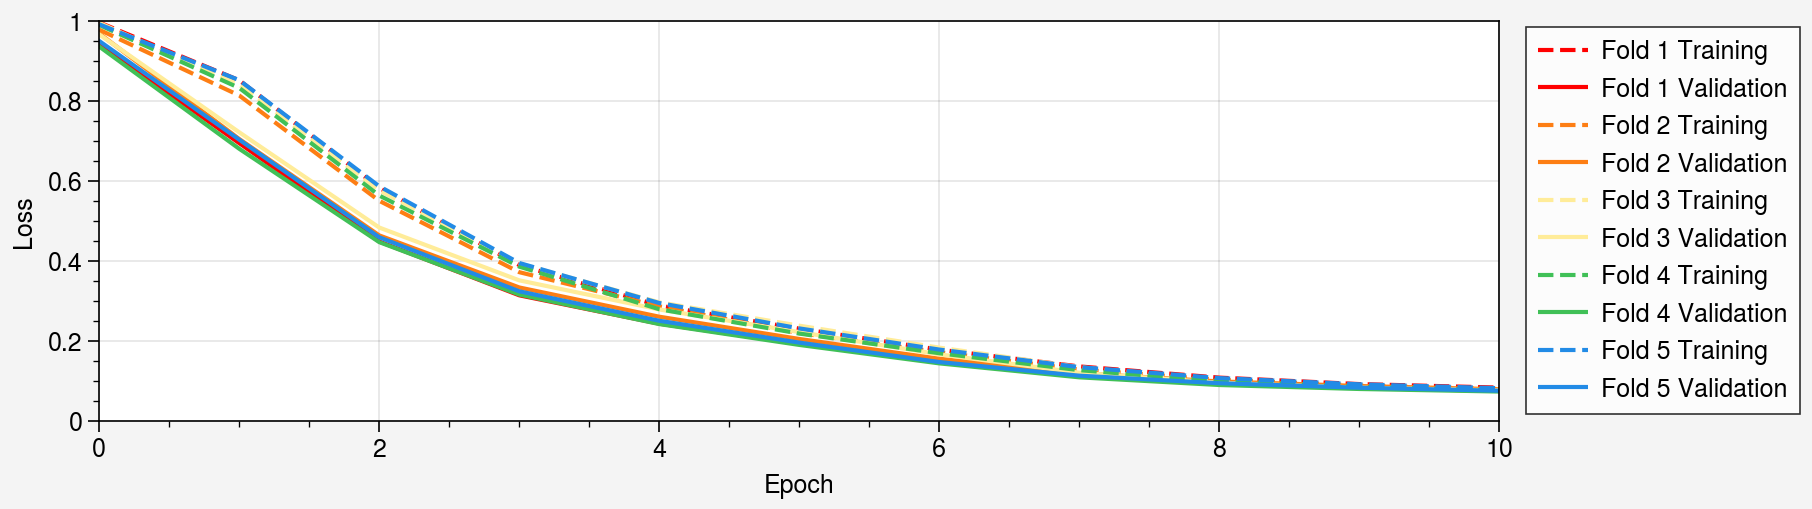

In [98]:
# Plot training and validation losses
fig,ax = pplt.subplots(ncols=1,nrows=1,refwidth=7,refheight=2)
ax.format(xlim=(0,10),xlabel='Epoch',ylim=(0,1),ylabel='Loss')
for fold,color in zip(range(kfolds),['r','orange6','yellow2','green6','blue6']):
    ax.plot(foldtrainlosses[fold],color=color,linestyle='--',label=f'Fold {fold+1} Training')
    ax.plot(foldvallosses[fold],color=color,label=f'Fold {fold+1} Validation')
ax.legend(loc='r',ncols=1)
pplt.show()

In [106]:
# Final evaluation on test set
testloader = DataLoader(testdataset,batch_size=batchsize,shuffle=False)
testloss,testr2,testrmse = evaluate_model(model,testloader,criterion,device)
print(f'Test Loss: {testloss:.4f}, R2 Score: {testr2:.4f}, RMSE: {testrmse:.4f}')

Test Loss: 0.0561, R2 Score: 0.9436, RMSE: 0.2366


In [ ]:
# Denormalize predictions for final plot
model.eval()
with torch.no_grad():
    xtest = testdataset.dataset.tensors[0].to(device)
    ypred = model(xtest).cpu().numpy().flatten()
    ytrue = testdataset.dataset.tensors[1].cpu().numpy().flatten()

xtestdenorm = xtest.cpu().numpy().flatten()*xstd+xmean
ypreddenorm = ypred*ystd+ymean
ytruedenorm = ytrue*ystd+ymean

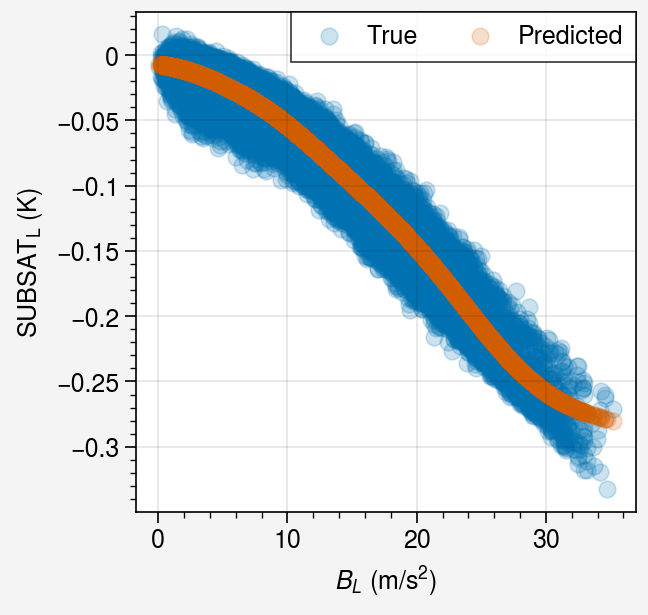

In [105]:
# Final plot
fig,ax = pplt.subplots(nrows=1,ncols=1)
ax.format(xlabel='$\mathit{B_L}$ (m/s$^2$)',ylabel='$\mathrm{SUBSAT_L}$ (K)')
ax.scatter(xtestdenorm,ytruedenorm,alpha=0.2,label='True')
ax.scatter(xtestdenorm,ypreddenorm,alpha=0.2,label='Predicted')
ax.legend()
pplt.show()

In [34]:
# Create a class for our custom Pytorch dataset
class CustomDataset(TensorDataset):
    def __init__(self,x,y):
        self.x = x
        self.y = y
    def __len__(self):
        return len(self.x)
    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]

# Make the dataset from our input/target tensors
dataset = CustomDataset(xtensor,ytensor)
print(f'Custom dataset size: {len(dataset)}')

Custom dataset size: 108192


In [37]:
# Create a DataLoader
BATCHSIZE = 322
dataloader = DataLoader(dataset,batch_size=BATCHSIZE,shuffle=True,num_workers=2)

# Inspect a batch
for batch in dataloader:
    x,y = batch
    print(f'Inputs batch size: {x.shape}, Targets batch size: {y.shape}')
    break

Inputs batch size: torch.Size([322, 1]), Targets batch size: torch.Size([322, 1])


In [50]:
# from sklearn.model_selection import KFold
# from torch.utils.data import Subset

# K-fold cross-validation is a useful data validation technique when you have limited samples, 
# because you use the whole dataset for training and validation. 
#
# - It divides the data into "K" equal-sized subsets ("folds")
# - The model is trained and validated "K" times
# - In each iteration, 1 subset is used for validation, the rest for training, so each subset is used as the validation set once

# Initialize KFold
kfold = KFold(n_splits=5,shuffle=True,random_state=42)

# Split the dataset into 5 folds
for fold,(trainidx,validx) in enumerate(kfold.split(dataset)):
    print(f'Fold {fold+1}:')
    print(f'  Indices - Training: {trainidx[:5]}, Validation: {validx[:5]}')

    # Create subsets for training and validation
    trainsubset = Subset(dataset,trainidx)
    valsubset   = Subset(dataset,validx)
    print(f'  Subset Size - Training: {len(trainsubset)}, Validation: {len(valsubset)}')

    # Wrap subsets in DataLoader objects for batchingand efficient loading
    trainloader = DataLoader(trainsubset,batch_size=BATCHSIZE,shuffle=True,num_workers=2)
    valloader   = DataLoader(valsubset,batch_size=BATCHSIZE,shuffle=False,num_workers=2)

    # Check a batch
    for x,y in trainloader:
        print(f'  Batch Size: {x.shape}')
        break

Fold 1:
  Indices - Training: [0 1 2 4 5], Validation: [ 3 23 24 35 39]
  Subset Size - Training: 86553, Validation: 21639
  Batch Size: torch.Size([322, 1])
Fold 2:
  Indices - Training: [0 2 3 4 5], Validation: [ 1  7  8 12 17]
  Subset Size - Training: 86553, Validation: 21639
  Batch Size: torch.Size([322, 1])
Fold 3:
  Indices - Training: [1 2 3 5 7], Validation: [ 0  4  6 11 13]
  Subset Size - Training: 86554, Validation: 21638
  Batch Size: torch.Size([322, 1])
Fold 4:
  Indices - Training: [0 1 2 3 4], Validation: [ 9 10 14 16 19]
  Subset Size - Training: 86554, Validation: 21638
  Batch Size: torch.Size([322, 1])
Fold 5:
  Indices - Training: [0 1 3 4 6], Validation: [ 2  5 15 18 20]
  Subset Size - Training: 86554, Validation: 21638
  Batch Size: torch.Size([322, 1])


In [54]:
# Define the model
class MLP(torch.nn.Module):
    def __init__(self):
        super(MLP,self).__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(1,64),
            torch.nn.Softmax(),
            torch.nn.Linear(64,64),
            torch.nn.Softmax(),
            torch.nn.Linear(64,1))
    def forward(self,x):
        return self.layers(x)

In [60]:
# Function to train the model for 1 epoch
def train_one_epoch(model,dataloader,optimizer,lossfunction,device):
    model.train()
    for inputs,targets in dataloader:
        inputs,targets = inputs.to(device),targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss    = lossfunction(outputs,targets)
        loss.backward()
        optimizer.step()
    print(f'Training Loss: {loss.item()}')

# Training example
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model  = MLP().to(device)
optimizer    = torch.optim.Adam(model.parameters(),lr=0.005)
lossfunction = torch.nn.MSELoss()
train_one_epoch(model,trainloader,optimizer,lossfunction,device)

# After each fold, save the model's state for future use
# torch.save(model.state_dict(), f'model_fold_{fold}.pth')

Training Loss: 0.17344535887241364


In [ ]:
import torch.multiprocessing as mp

def train_fold(fold, train_subset, val_subset):
    # Training logic for one fold
    pass

# Parallelize folds
mp.spawn(train_fold, args=(train_subset, val_subset), nprocs=5)

In [19]:
trainlosses = []
vallosses   = []
r2scores    = []


# Set up cross-validation
NSPLITS = 5
# Initialize KFold
kfold = KFold(n_splits=NSPLITS,shuffle=True,random_state=42)


# Split the datasets into folds
for fold,(trainidx,validx) in enumerate(kfold.split(xtensor)):
    print(f'Fold {fold+1}/{NSPLITS}')
    
    # Split data into training and validation subsets
    xtrain,xval = xtensor[trainidx],xtensor[validx]
    ytrain,yval = ytensor[trainidx],ytensor[validx]
    
    # Create data loaders
    traindataset = TensorDataset(xtrain,ytrain)
    valdataset   = TensorDataset(xval,yval)

    
    trainloader  = DataLoader(traindataset,batch_size=BATCHSIZE,shuffle=True)
    valloader    = DataLoader(valdataset,batch_size=BATCHSIZE,shuffle=False)
    
    # Initialize model, loss function, and optimizer
    model = MLP(input_size, hidden_size, output_size)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Training loop
    for epoch in range(n_epochs):
        model.train()
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
    
    # Validation
    model.eval()
    val_loss = 0
    predictions = []
    actuals = []
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            outputs = model(batch_x)
            val_loss += criterion(outputs, batch_y).item()
            predictions.extend(outputs.numpy())
            actuals.extend(batch_y.numpy())
    
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    
    # Calculate R2 score
    predictions = np.array(predictions).flatten()
    actuals = np.array(actuals).flatten()
    r2 = r2_score(actuals, predictions)
    r2_scores.append(r2)
    
    print(f"Validation Loss: {val_loss:.4f}, R2 Score: {r2:.4f}")

# Print average results
print(f"Average Validation Loss: {np.mean(val_losses):.4f}")
print(f"Average R2 Score: {np.mean(r2_scores):.4f}")

Fold 1/5
Validation Loss: 0.0569, R2 Score: 0.9423
Fold 2/5



KeyboardInterrupt



In [1]:
# fig,axs = pplt.subplots(nrows=1,ncols=3,refwidth=2,share=False)
# axs[0].format(title='Histogram of $SUBSAT_L$',xlabel='$SUBSAT_L$ (K)',yscale='log',yformatter='log')
# axs[1].format(title='Histogram of $\mathit{B_L}$',xlabel='$\mathit{B_L}$ (m/s$^2$)',ylabel='Count',yscale='log',yformatter='log')
# axs[2].format(title='$SUBSAT_L$ vs. $\mathit{B_L}$',xlabel='$SUBSAT_L$ (K)',ylabel='$\mathit{B_L}$ (m/s$^2$)')
# axs[0].hist(x.values.flatten(),bins=50,filled=True,color='cyan6',alpha=0.5)
# axs[1].hist(y.values.flatten(),bins=50,filled=True,color='pink6',alpha=0.5)
# axs[2].scatter(x.values.flatten(),y.values.flatten(),color='k',marker='.',markersize=10,alpha=0.2)
# pplt.show()

In [9]:
def subset(x,y,startyear,endyear):
    years   = np.arange(startyear,endyear+1)
    xsubset = x.sel(time=x['time.year'].isin(years))
    ysubset = y.sel(time=y['time.year'].isin(years))
    return xsubset.values.flatten().astype(np.float64),ysubset.values.flatten().astype(np.float64)

def normalize(array,mean=None,std=None):
    if mean is None:
        mean = np.mean(array)
    if std is None:
        std  = np.std(array)
    return (array-mean)/std,mean,std

def preprocess(x,y,years,training=True,normparams=None):
    xarray,yarray = subset(x,y,years[0],years[1])
    if training:
        xnorm,xmean,xstd = normalize(xarray)
        ynorm,ymean,ystd = normalize(yarray)
        normparams = {'xmean':xmean,'xstd':xstd,'ymean':ymean,'ystd':ystd}
    else:
        if normparams is None:
            raise ValueError("'normparams' must be provided for validation and test sets.")
        xnorm,_,_ = normalize(xarray,normparams['xmean'],normparams['xstd'])
        ynorm,_,_ = normalize(yarray,normparams['ymean'],normparams['ystd'])
    xtensor = torch.FloatTensor(xnorm)
    ytensor = torch.FloatTensor(ynorm)
    return (xtensor,ytensor,normparams) if training else (xtensor,ytensor)

trainyears = (2000,2005)
valyears   = (2006,2007)
testyears  = (2008,2009)
xtrain,ytrain,normparams = preprocess(x,y,trainyears,training=True,normparams=False)
xval,yval   = preprocess(x,y,valyears,training=False,normparams=normparams)
xtest,ytest = preprocess(x,y,testyears,training=False,normparams=normparams)

In [10]:
class DATASET(TensorDataset):
    def __init__(self,xtensor,ytensor):
        self.inputs  = xtensor.view(-1,1)
        self.targets = ytensor.view(-1,1)
    def __getitem__(self,index):
        onex = self.inputs[index]
        oney = self.targets[index]
        return onex,oney
    def __len__(self):
        return self.targets.shape[0]

traindataset = DATASET(xtrain,ytrain)
valdataset   = DATASET(xval,yval)
testdataset  = DATASET(xtest,ytest)

In [11]:
def batch(tensor1,tensor2):
    def factors(n):
        factors = set()
        for i in range(1,int(n**0.5)+1):
            if n%i==0:
                factors.add(i)
                factors.add(n//i)
        return factors
    n1 = tensor1.shape[0]
    n2 = tensor2.shape[0]
    commonfactors   = factors(n1).intersection(factors(n2))
    validbatchsizes = [f for f in commonfactors if 50<=f<=800]
    for batchsize in validbatchsizes:
        print(f'Batch Size: {batchsize:<3} | Tensor 1: {n1//batchsize:<3} batches | Tensor 2: {n2//batchsize:<3} batches')

batch(xtrain,xval)

Batch Size: 644 | Tensor 1: 48  batches | Tensor 2: 16  batches
Batch Size: 161 | Tensor 1: 192 batches | Tensor 2: 64  batches
Batch Size: 56  | Tensor 1: 552 batches | Tensor 2: 184 batches
Batch Size: 184 | Tensor 1: 168 batches | Tensor 2: 56  batches
Batch Size: 448 | Tensor 1: 69  batches | Tensor 2: 23  batches
Batch Size: 322 | Tensor 1: 96  batches | Tensor 2: 32  batches
Batch Size: 64  | Tensor 1: 483 batches | Tensor 2: 161 batches
Batch Size: 92  | Tensor 1: 336 batches | Tensor 2: 112 batches
Batch Size: 736 | Tensor 1: 42  batches | Tensor 2: 14  batches
Batch Size: 224 | Tensor 1: 138 batches | Tensor 2: 46  batches
Batch Size: 368 | Tensor 1: 84  batches | Tensor 2: 28  batches
Batch Size: 112 | Tensor 1: 276 batches | Tensor 2: 92  batches


In [12]:
BATCHSIZE   = 322
trainloader = DataLoader(dataset=traindataset,batch_size=BATCHSIZE,shuffle=True)
valloader   = DataLoader(dataset=traindataset,batch_size=BATCHSIZE,shuffle=True)
testloader  = DataLoader(dataset=testdataset,batch_size=BATCHSIZE,shuffle=False)

In [15]:
class MLP(torch.nn.Module):
    def __init__(self,inputsize,hiddensize,outputsize,activation):
        super(MLP,self).__init__()                  
        self.activation = activation() 
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(inputsize,hiddensize),  
            self.activation,
            torch.nn.Linear(hiddensize,hiddensize),
            self.activation,
            torch.nn.Linear(hiddensize,outputsize))
    def forward(self,x):
        logits = self.layers(x)
        return logits

INPUTSIZE  = 1
OUTPUTSIZE = 1
HIDDENSIZE = 64
ACTIVATION = torch.nn.Softmax

model = MLP(INPUTSIZE,HIDDENSIZE,OUTPUTSIZE,ACTIVATION)
print(model)

nparams = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of Trainable Parameters:',nparams)

MLP(
  (activation): Softmax(dim=None)
  (layers): Sequential(
    (0): Linear(in_features=1, out_features=64, bias=True)
    (1): Softmax(dim=None)
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Softmax(dim=None)
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)
Number of Trainable Parameters: 4353


In [16]:
CRITERION = torch.nn.MSELoss()
LEARNING  = 0.005
OPTIMIZER = torch.optim.Adam(model.parameters(),lr=LEARNING)

In [17]:
def train(model,trainloader,criterion,optimizer):
    model.train()
    runningloss = 0.0
    for inputs,targets in trainloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss    = criterion(outputs,targets)
        loss.backward()
        optimizer.step()
        runningloss += loss.item()*inputs.size(0)
    return runningloss/len(trainloader.dataset)

def validate(model,valloader,criterion):
    model.eval()
    runningloss = 0.0
    with torch.no_grad():
        for inputs,targets in valloader:
            outputs = model(inputs)
            loss    = criterion(outputs,targets)
            runningloss += loss.item()*inputs.size(0)
    return runningloss/len(valloader.dataset)

NEPOCHS     = 20
trainlosses = []
vallosses   = []
for epoch in range(1,NEPOCHS+1):
    trainloss = train(model,trainloader,CRITERION,OPTIMIZER)
    valloss   = validate(model,valloader,CRITERION)
    trainlosses.append(trainloss)
    vallosses.append(valloss)
    print(f'Epoch: {epoch:2d}/{NEPOCHS:2d} | Training Loss: {trainloss:.4f}, Validation Loss: {valloss:.4f}')

Epoch:  1/20 | Training Loss: 0.9301, Validation Loss: 0.7297
Epoch:  2/20 | Training Loss: 0.4772, Validation Loss: 0.3090
Epoch:  3/20 | Training Loss: 0.2356, Validation Loss: 0.1695
Epoch:  4/20 | Training Loss: 0.1163, Validation Loss: 0.0813
Epoch:  5/20 | Training Loss: 0.0685, Validation Loss: 0.0609
Epoch:  6/20 | Training Loss: 0.0568, Validation Loss: 0.0539
Epoch:  7/20 | Training Loss: 0.0523, Validation Loss: 0.0510
Epoch:  8/20 | Training Loss: 0.0503, Validation Loss: 0.0495
Epoch:  9/20 | Training Loss: 0.0494, Validation Loss: 0.0492
Epoch: 10/20 | Training Loss: 0.0487, Validation Loss: 0.0484
Epoch: 11/20 | Training Loss: 0.0483, Validation Loss: 0.0481
Epoch: 12/20 | Training Loss: 0.0482, Validation Loss: 0.0482
Epoch: 13/20 | Training Loss: 0.0481, Validation Loss: 0.0479
Epoch: 14/20 | Training Loss: 0.0480, Validation Loss: 0.0487
Epoch: 15/20 | Training Loss: 0.0482, Validation Loss: 0.0478
Epoch: 16/20 | Training Loss: 0.0480, Validation Loss: 0.0479
Epoch: 1

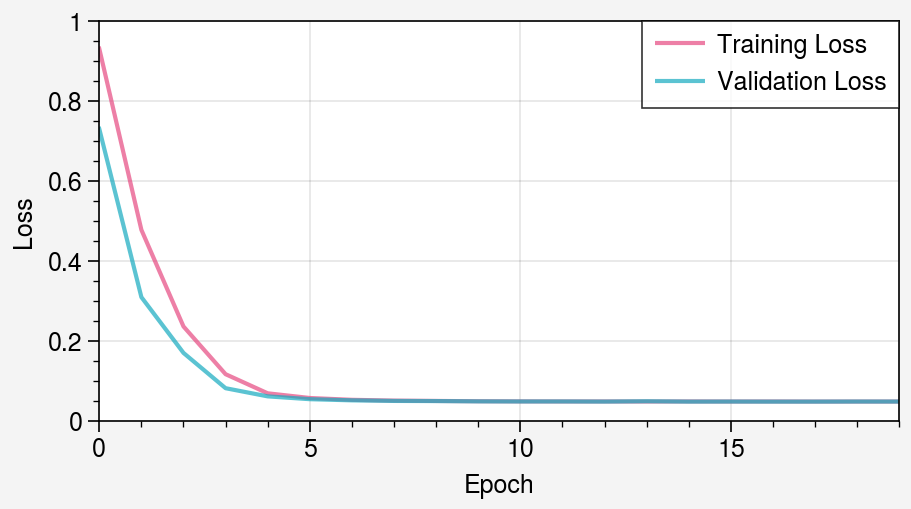

In [18]:
fig,ax = pplt.subplots(nrows=1,ncols=1,refheight=2,refwidth=4)
ax.format(xlabel='Epoch',xticks=5,ylabel='Loss',ylim=(0,1))
ax.plot(trainlosses,color='pink6',alpha=0.7,label='Training Loss')
ax.plot(vallosses,color='cyan6',alpha=0.7,label='Validation Loss')
ax.legend(loc='ur',ncols=1)
pplt.show()

In [22]:
def test(model,testloader,criterion):
    model.eval()
    runningloss = 0.0
    alloutputs  = []
    with torch.no_grad():
        for inputs,targets in testloader:
            outputs = model(inputs)
            loss    = criterion(outputs,targets)
            runningloss += loss.item()*inputs.size(0)
            alloutputs.append(outputs.cpu().numpy())
    return runningloss/len(testloader.dataset),np.array(np.concatenate(alloutputs).flatten())

testloss,ypred = test(model,testloader,CRITERION)
print(f'Test Loss: {testloss:.4f}')

Test Loss: 0.0541


In [23]:
def denormalize(normtensor,mean,std):
    return np.array(normtensor)*std+mean

realbl = denormalize(ytest,normparams['ymean'],normparams['ystd'])
predbl = denormalize(ypred,normparams['ymean'],normparams['ystd'])

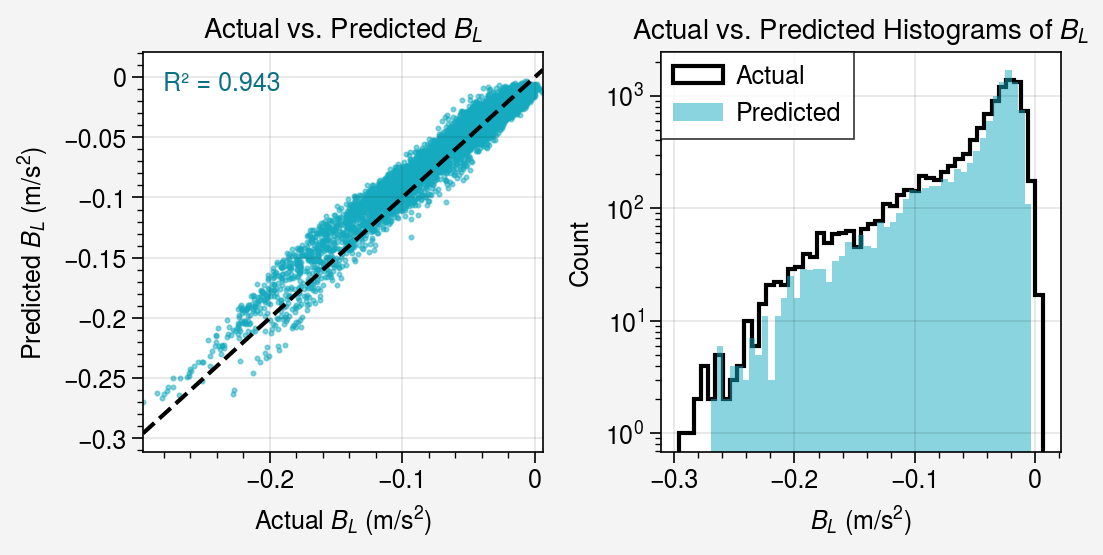

In [25]:
fig,axs = pplt.subplots(nrows=1,ncols=2,refwidth=2,share=False)
axs[0].format(title='Actual vs. Predicted $\mathit{B_L}$',xlabel='Actual $\mathit{B_L}$ (m/s$^2$)',ylabel='Predicted $\mathit{B_L}$ (m/s$^2$)')
axs[1].format(title='Actual vs. Predicted Histograms of $\mathit{B_L}$',xlabel='$\mathit{B_L}$ (m/s$^2$)',ylabel='Count',yscale='log',yformatter='log')
axs[0].scatter(realbl,predbl,color='cyan6',marker='.',markersize=10,alpha=0.5)
axs[0].plot([min(min(realbl),min(predbl)),max(max(realbl),max(predbl))],[min(min(realbl),min(predbl)),max(max(realbl),max(predbl))],'k--')
axs[0].text(0.05,0.95,f'RÂ² = {r2_score(realbl,predbl):.3f}',color='cyan9',transform=axs[0].transAxes,verticalalignment='top',horizontalalignment='left')
axs[1].hist(realbl,bins=50,filled=True,facecolor='none',edgecolor='k',linewidth=1.5,label='Actual')
axs[1].hist(predbl,bins=50,filled=True,color='cyan6',alpha=0.5,label='Predicted')
axs[1].legend(loc='ul',ncols=1)
pplt.show()